# 1. Data Load

In [1]:
import numpy as np
import pandas as pd
import math

from scipy import stats #Analysis 
from scipy.stats import norm 

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline

In [2]:
path = "./Dataset/"

data = pd.read_csv(path+"kwproja_data_location.csv")
#data = pd.read_csv('../input/dolphin-kwproja-bigdata/kwproja_data_big.csv')

# original data -> data
data

,DATE_,SHOP_CODE,SHOP_NAME,SHOP_TYPE_BIG,SHOP_TYPE_SMALL,LONGITUDE,LATITUDE,MONTHLY_GAIN,AVERAGE_SALE_PRICE,GU,DONG
0,201709,68281950112,대원갈비,뷔페,고기 뷔페,126.928985,37.486131,88292576.82,43319,관악구,신림동
1,201709,491680110,옛골토성,뷔페,고기 뷔페,126.950087,37.655256,25218858.16,63645,은평구,진관동
2,201708,4540650109,정든생삼겹살,뷔페,고기 뷔페,126.820341,37.572506,25957122.44,61605,강서구,방화1동
3,201708,42631710113,손가네생오리부페,뷔페,고기 뷔페,126.855748,37.493473,17709655.91,36938,구로구,개봉2동
4,201709,70824420108,한방복돼지,뷔페,고기 뷔페,127.133802,37.533616,24859801.35,58224,강동구,성내3동
...,...,...,...,...,...,...,...,...,...,...,...
2927734,201804,1709900344,신지도수산,수산물,회/수산물 일반,126.936846,37.514666,12570901.91,73033,동작구,노량진2동
2927735,201803,51063560503,노랑태 황태찜,수산물,회/수산물 일반,126.930924,37.621990,10489984.69,24402,은평구,불광2동
2927736,201803,5919500296,스마일수산,수산물,회/수산물 일반,126.917492,37.484891,31807992.77,16458,관악구,신사동
2927737,201805,4459300560,샛강,수산물,회/수산물 일반,126.936846,37.514666,7725388.62,71400,동작구,노량진2동


# 2. EDA 

2,927,739 rows X 11 columns

- 매장 속성 정보
  - shop_code -> 식별자 feature => drop   
  - shop_name => DL
  - longtitude : 경도, latitude : 위도 -> 매장 위치 (회사 근처, 학교 근처 등 매출 영향성 있음) -> K-mean clustering => geo, ML, DL
  - address1, address2 : GeoEncoder를 통해 따로 얻은 행정동, 1(30), 2(436) => DL
  - shop_type_big -> 15 category, shop_type_big_label, ML => DL
  - shop_type_small -> 61 category, shop_type_small_label, ML => DL 

- 매출 정보
  - date -> 24 category, 201606~ 201805 까지의 data
  - monthly_gain / avearge_sale_price = 한달 총 판매수

- 매출 통계 정보-> X

In [3]:
# rename data columns and check the data
data.columns = ['date', 'shop_code', 'shop_name', 'shop_type_big', 'shop_type_small', 
                'longitude', 'latitude', 'monthly_gain', 'average_sale_price', 'address1', 'address2']

print(data.columns, '\n')
print(data.info())

Index(['date', 'shop_code', 'shop_name', 'shop_type_big', 'shop_type_small',
       'longitude', 'latitude', 'monthly_gain', 'average_sale_price',
       'address1', 'address2'],
      dtype='object') 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2927739 entries, 0 to 2927738
Data columns (total 11 columns):
 #   Column              Dtype  
---  ------              -----  
 0   date                int64  
 1   shop_code           int64  
 2   shop_name           object 
 3   shop_type_big       object 
 4   shop_type_small     object 
 5   longitude           float64
 6   latitude            float64
 7   monthly_gain        float64
 8   average_sale_price  int64  
 9   address1            object 
 10  address2            object 
dtypes: float64(3), int64(3), object(5)
memory usage: 245.7+ MB
None


# 3. Preprocessing
data -> processed_data
- 9 columns : **shop_code | date | shop_name | shop_type_big | shop_type_small | longitude | latitude | average_sale_price | monthly_gain**
- shop_code : 식별자 feature 이므로 drop 
- date : 아직은 쓸 수 없으므로 drop
- missing value 제거 : A/N
- shop_type_big(15), shop_type_small(61) 
    - ML : label encodding
    - DL : NLP
- longitude, latitude : 
    - ML : k-mean clustering -> geo column 
    - DL : NLP, reverse geo encoder(행정동, 법정동, 지번주소, 도로명주소) -> 지번주소 가져오세요(for web) 
    - 행정동admcode, 법정동legalcode -> area1, area2, area3, area4
    - 지번 주소addr -> area1, area2, area3, area4 (x), land -> namber1, number2
    - 도로명 주소roadaddr -> area1, area2, area3, area4(x), land -> number1, number2, name  
- average_sale_price 
    - log transformation 
- MinMaxSaclar 정규화 -> 정규화 column의 범위는?? 실험필요 요인 

In [4]:
# 원본 data와 따로 관리 -> original data = data, preprocessed data = processed_data 
# feature drop : date, shop_code
processed_data = data.drop(['date', 'shop_code'], axis=1).copy()

In [5]:
# There are no missing values 
# missing value drop - monthly_gain
null_index = processed_data[processed_data['monthly_gain']==0].index 
print("monthly gain null : ", len(null_index))
processed_data = processed_data.drop(null_index)

# missing value drop - average_sale_price
null_index = processed_data[processed_data['average_sale_price']==0].index 
print("average sale price null : ", len(null_index))
processed_data = processed_data.drop(null_index)

# missing value drop - shop_type_big
null_index = processed_data[processed_data['shop_type_big'].isnull()==True].index
print("shop type big null : ", len(null_index))
print("shop type big unique : ", processed_data['shop_type_big'].nunique())
processed_data = processed_data.drop(null_index)

# missing value drop - shop_type_small 
null_index = processed_data[processed_data['shop_type_small'].isnull()==True].index
print("shop type small null : ", len(null_index))
print("shop type small unique : ", processed_data['shop_type_small'].nunique() )

monthly gain null :  0
average sale price null :  0
shop type big null :  0
shop type big unique :  15
shop type small null :  0
shop type small unique :  61


In [6]:
# LabelEncoder
from sklearn.preprocessing import LabelEncoder

# fit transform으로 한번에 처리 가능
le = LabelEncoder()
processed_data['shop_type_big_label'] = le.fit_transform(list(processed_data['shop_type_big']))   
print(le.classes_)

le = LabelEncoder()
processed_data['shop_type_small_label'] = le.fit_transform(list(processed_data['shop_type_small'])) 
print(le.classes_)

['다방/커피숍/카페' '별식/퓨전요리' '분식' '뷔페' '생활서비스' '소매' '수산물' '양식' '유흥주점' '음식-미분류'
 '일식' '제과제빵떡케익' '중식' '패스트푸드' '한식']
['고기 뷔페' '고기구이/육회 전문점' '곱창/양구이 전문점' '구내식당' '국수/수제비 전문점' '기타세계요리 전문점'
 '낙지/문어/오징어/쭈꾸미 전문점' '냉면 전문점' '덮밥/가정식' '도너츠/꽈배기/고로케/호떡 전문점'
 '도시락/컵밥/주먹밥/배달음식 전문점' '돈가스 전문점' '떡/한과 전문점' '마라/양꼬치/훠궈 전문점' '면 전문점'
 '미분류 유흥업소' '민속주점' '바닷가재/게요리 전문점' '반찬 판매' '백화점' '버거 전문점' '베트남음식 전문점'
 '보쌈/족발 전문점' '분식 전문점' '샌드위치/토스트/핫도그 전문점' '샤브샤브 전문점' '세탁소' '소주방/포장마차'
 '순대 전문점' '슈퍼/잡화/할인매장' '스테이크 전문점' '식료품' '아이스크림/빙수 판매' '오리/닭요리 전문점'
 '오리/닭요리/탕/백숙 전문점' '와인/칵테일/위스키 바' '음식-미분류' '이자까야/꼬치구이' '이태리 전문점'
 '인도음식 전문점' '일반 중식당' '장어 전문점' '전통찻집' '제과/제빵 전문점' '조개 전문점' '종합 뷔페'
 '죽요리 전문점' '참치 전문점' '초밥 전문점' '치킨/닭강정 전문점' '카레 전문점' '카페/디저트' '테이크아웃 음료 전문점'
 '편의점' '퓨전음식 전문점' '피자 전문점' '한식국물요리 전문점' '한정식/백반 전문점' '호프/맥주' '화로구이 전문점'
 '회/수산물 일반']


In [7]:
# BinaryEncoder for categorical variable 
import category_encoders as ce

encoder = ce.BinaryEncoder(cols=["shop_type_big", "shop_type_small"])
df = encoder.fit_transform(processed_data[["shop_type_big", "shop_type_small"]])

processed_data = pd.concat([processed_data, df], axis=1)

C:\Users\mtang\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [8]:
# NLP용 preprocessing 
# shop_name, shop_type_big, shop_type_small = concat_text 
processed_data['text'] = processed_data['shop_name'] + ' ' + processed_data['shop_type_big'] + ' ' + processed_data['shop_type_small']
processed_data['address'] = processed_data['address1'] + ' ' + processed_data['address2']
processed_data['concat_text'] = processed_data['text'] + ' ' + processed_data['address']
processed_data = processed_data.drop(['text', 'shop_name', 'shop_type_big', 'shop_type_small', 'address', 'address1', 'address2'], axis=1)

[[ 37.50143998 127.03448001]
 [ 37.57399183 126.92466663]
 [ 37.6389035  127.04533766]
 [ 37.49488319 126.89661258]
 [ 37.57053774 127.06815393]
 [ 37.53989547 126.84569676]
 [ 37.56628199 126.99494231]
 [ 37.49675804 126.95195041]
 [ 37.51700472 127.12122086]]
[7 1 5 ... 3 7 0]


C:\Users\mtang\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


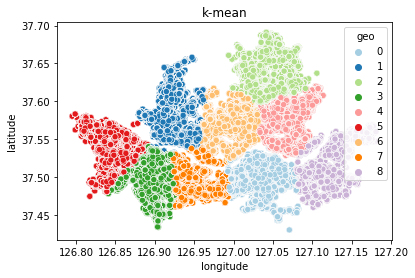

In [9]:
# Labeling - KMeans Clustering 
# longitude + latitude = geo 
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=9).fit(processed_data[['latitude', 'longitude']])
print(kmeans.cluster_centers_)
print(kmeans.labels_)

processed_data['geo'] = kmeans.labels_

# plotting geo
sns.scatterplot(x='longitude' , y='latitude', hue="geo", data=processed_data, palette="Paired")
plt.title('k-mean')

processed_data = processed_data.drop(['longitude', 'latitude'], axis=1)

In [10]:
# average_sale_price -> skewed data 
# log transfromation 
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, Normalizer

scale_cols = ['average_sale_price']
processed_data[scale_cols] = processed_data[scale_cols].apply(lambda x : np.log1p(x))

processed_data

,monthly_gain,average_sale_price,shop_type_big_label,shop_type_small_label,shop_type_big_0,shop_type_big_1,shop_type_big_2,shop_type_big_3,shop_type_big_4,shop_type_small_0,shop_type_small_1,shop_type_small_2,shop_type_small_3,shop_type_small_4,shop_type_small_5,shop_type_small_6,concat_text,geo
0,88292576.82,10.676370,3,0,0,0,0,0,1,0,0,0,0,0,0,1,대원갈비 뷔페 고기 뷔페 관악구 신림동,7
1,25218858.16,11.061092,3,0,0,0,0,0,1,0,0,0,0,0,0,1,옛골토성 뷔페 고기 뷔페 은평구 진관동,1
2,25957122.44,11.028515,3,0,0,0,0,0,1,0,0,0,0,0,0,1,정든생삼겹살 뷔페 고기 뷔페 강서구 방화1동,5
3,17709655.91,10.517023,3,0,0,0,0,0,1,0,0,0,0,0,0,1,손가네생오리부페 뷔페 고기 뷔페 구로구 개봉2동,3
4,24859801.35,10.972070,3,0,0,0,0,0,1,0,0,0,0,0,0,1,한방복돼지 뷔페 고기 뷔페 강동구 성내3동,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2927734,12570901.91,11.198680,6,60,0,0,1,0,1,0,1,1,1,1,0,0,신지도수산 수산물 회/수산물 일반 동작구 노량진2동,7
2927735,10489984.69,10.102461,6,60,0,0,1,0,1,0,1,1,1,1,0,0,노랑태 황태찜 수산물 회/수산물 일반 은평구 불광2동,1
2927736,31807992.77,9.708628,6,60,0,0,1,0,1,0,1,1,1,1,0,0,스마일수산 수산물 회/수산물 일반 관악구 신사동,3
2927737,7725388.62,11.176067,6,60,0,0,1,0,1,0,1,1,1,1,0,0,샛강 수산물 회/수산물 일반 동작구 노량진2동,7


# 4. Target Variable Labeling and EDA for variable y
processed_data -> labeled_data 
- 어떻게 라벨링 할 것인가? 
- 1. Classification : use mean, std -> failed
- 2. Classification : Quantile 10%, 20%, 25%, 33% -> label 10, 5, 4, 3 
- 3. Classification : Quantile by shop_type_big with lower fence, Q2, upper_fence -> label 31
- 3. **Classification : Quantile by shop_type_big with Q1, Q2, Q3 -> label 45** 
- 4. Classification : price label, min:5, max:181억 -> label 15
- 5. Removing Outlier : outler 233,140 -> total data(without outlier) 2,694,599
- 6. Rounding data 

In [11]:
# pandas option 설정 하는 코드
# monthly_gain의 경우 부동소수점으로 나타나서 보기 어려울땐 윗 줄의 주석을 제거하고 아래에 주석을 추가하고
# 다시 원래대로 돌리고 싶다면 아래에 주석제거, 위 코드에 주석추가
pd.options.display.float_format = '{:.2f}'.format
#pd.reset_option('display.float_format')

# 전처리된 data와 따로 관리 -> preprocessed data = procssed_data, labeled data = labeled_data 
labeled_data = processed_data.copy()
labeled_data

,monthly_gain,average_sale_price,shop_type_big_label,shop_type_small_label,shop_type_big_0,shop_type_big_1,shop_type_big_2,shop_type_big_3,shop_type_big_4,shop_type_small_0,shop_type_small_1,shop_type_small_2,shop_type_small_3,shop_type_small_4,shop_type_small_5,shop_type_small_6,concat_text,geo
0,88292576.82,10.68,3,0,0,0,0,0,1,0,0,0,0,0,0,1,대원갈비 뷔페 고기 뷔페 관악구 신림동,7
1,25218858.16,11.06,3,0,0,0,0,0,1,0,0,0,0,0,0,1,옛골토성 뷔페 고기 뷔페 은평구 진관동,1
2,25957122.44,11.03,3,0,0,0,0,0,1,0,0,0,0,0,0,1,정든생삼겹살 뷔페 고기 뷔페 강서구 방화1동,5
3,17709655.91,10.52,3,0,0,0,0,0,1,0,0,0,0,0,0,1,손가네생오리부페 뷔페 고기 뷔페 구로구 개봉2동,3
4,24859801.35,10.97,3,0,0,0,0,0,1,0,0,0,0,0,0,1,한방복돼지 뷔페 고기 뷔페 강동구 성내3동,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2927734,12570901.91,11.20,6,60,0,0,1,0,1,0,1,1,1,1,0,0,신지도수산 수산물 회/수산물 일반 동작구 노량진2동,7
2927735,10489984.69,10.10,6,60,0,0,1,0,1,0,1,1,1,1,0,0,노랑태 황태찜 수산물 회/수산물 일반 은평구 불광2동,1
2927736,31807992.77,9.71,6,60,0,0,1,0,1,0,1,1,1,1,0,0,스마일수산 수산물 회/수산물 일반 관악구 신사동,3
2927737,7725388.62,11.18,6,60,0,0,1,0,1,0,1,1,1,1,0,0,샛강 수산물 회/수산물 일반 동작구 노량진2동,7


#### Option) Removing outlier
upper fence, lower fence 외 값(outlier)을 제거합니다 
- 2,927,739 x 19   ->   2,694,599 x 19

In [12]:
def get_pricelist(i, data) :
    df = data[['shop_type_big_label','monthly_gain']].groupby('shop_type_big_label')
    Q1 = df.get_group(i)['monthly_gain'].quantile(0.25)
    Q2 = df.get_group(i)['monthly_gain'].quantile(0.5)
    Q3 = df.get_group(i)['monthly_gain'].quantile(0.75)
    IQR = Q3 - Q1
    lower_fence = Q1 - (1.5 * IQR)
    upper_fence = Q3 + (1.5 * IQR)
    if lower_fence <= 0 : lower_fence = 0
        
    return lower_fence, Q1, Q2, Q3, upper_fence

def remove_outlier(data, processed_data) :
    output_data = data.copy()
    for i in range(0,15) :
        lower_fence, Q1, Q2, Q3, upper_fence = get_pricelist(i, processed_data)
        shoptype_index = data[data.shop_type_big_label == i].index
        shoptype_data = data.iloc[shoptype_index, :]
        outlier_index = shoptype_data[shoptype_data.monthly_gain > upper_fence].index
        print("removed index in shop_type_big" , i, ": ", len(outlier_index))
        output_data = output_data.drop(outlier_index)
    return output_data 

labeled_data = remove_outlier(labeled_data, processed_data)
labeled_data

removed index in shop_type_big 0 :  25133
removed index in shop_type_big 1 :  15726
removed index in shop_type_big 2 :  12003
removed index in shop_type_big 3 :  2393
removed index in shop_type_big 4 :  1
removed index in shop_type_big 5 :  26678
removed index in shop_type_big 6 :  8612
removed index in shop_type_big 7 :  1188
removed index in shop_type_big 8 :  19350
removed index in shop_type_big 9 :  50532
removed index in shop_type_big 10 :  6064
removed index in shop_type_big 11 :  5384
removed index in shop_type_big 12 :  8360
removed index in shop_type_big 13 :  11580
removed index in shop_type_big 14 :  40136


,monthly_gain,average_sale_price,shop_type_big_label,shop_type_small_label,shop_type_big_0,shop_type_big_1,shop_type_big_2,shop_type_big_3,shop_type_big_4,shop_type_small_0,shop_type_small_1,shop_type_small_2,shop_type_small_3,shop_type_small_4,shop_type_small_5,shop_type_small_6,concat_text,geo
1,25218858.16,11.06,3,0,0,0,0,0,1,0,0,0,0,0,0,1,옛골토성 뷔페 고기 뷔페 은평구 진관동,1
2,25957122.44,11.03,3,0,0,0,0,0,1,0,0,0,0,0,0,1,정든생삼겹살 뷔페 고기 뷔페 강서구 방화1동,5
3,17709655.91,10.52,3,0,0,0,0,0,1,0,0,0,0,0,0,1,손가네생오리부페 뷔페 고기 뷔페 구로구 개봉2동,3
4,24859801.35,10.97,3,0,0,0,0,0,1,0,0,0,0,0,0,1,한방복돼지 뷔페 고기 뷔페 강동구 성내3동,8
5,2547094.82,8.85,3,0,0,0,0,0,1,0,0,0,0,0,0,1,행복한 맛집 뷔페 고기 뷔페 중구 필동,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2927734,12570901.91,11.20,6,60,0,0,1,0,1,0,1,1,1,1,0,0,신지도수산 수산물 회/수산물 일반 동작구 노량진2동,7
2927735,10489984.69,10.10,6,60,0,0,1,0,1,0,1,1,1,1,0,0,노랑태 황태찜 수산물 회/수산물 일반 은평구 불광2동,1
2927736,31807992.77,9.71,6,60,0,0,1,0,1,0,1,1,1,1,0,0,스마일수산 수산물 회/수산물 일반 관악구 신사동,3
2927737,7725388.62,11.18,6,60,0,0,1,0,1,0,1,1,1,1,0,0,샛강 수산물 회/수산물 일반 동작구 노량진2동,7


#### Option) Rounding data
십만원대, 백만원대 아래 가격들은 모두 반올림 하여 비슷한 label 값을 가지는 것들은 통일
- label의 개수를 줄임 45 -> 36
- 1의 자리~ 10,000의 자리 숫자들은 반올림하에 0으로 처리

In [13]:
#print("original monthly_gain_label counts : ", labeled_data['gain_label'].nunique())
#labeled_data['gain_label'] = labeled_data.gain_label.apply(lambda x : round(x, -5) if x < 10000000 else round(x, -6))

#print("rounded monthly_gain_label value counts :", labeled_data['gain_label'].nunique(), 
#      "\n", labeled_data['gain_label'].value_counts())

# 5. Data Split 
전처리 완료, 필요한 column을 input으로 넣고 train / valid / test data split 

In [14]:
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, GridSearchCV

# 전처리된 data와 따로 관리 -> labeled data = labeled_data, model input data = input_data
input_data = labeled_data.copy()

input_data_y = input_data['monthly_gain'].copy()
input_data_X = input_data.drop(['monthly_gain'], axis=1)

In [16]:
# train/ test data 로 split 
tr_val_X, test_X, tr_val_y, test_y = train_test_split(
    input_data_X, 
    input_data_y, 
    test_size = 0.2, 
    random_state = 42,
    shuffle=True
)

# valid/train 로 split
train_X, valid_X, train_y, valid_y = train_test_split(
    tr_val_X, 
    tr_val_y, 
    test_size = 0.2, 
    random_state = 42,
    shuffle=True
)

# 6. Modeling - ML, XGB, LGBM
- shop_type_big_label(0~4), shop_type_small_label(0~6), geo, average_sale_price
    - input feature : 14
- XGB
- LGBM 
    - tweedie?

In [17]:
# ml용 data에는 _ml을 붙여줍니다 
X_column_ml = ['average_sale_price', 'shop_type_big_0',
       'shop_type_big_1', 'shop_type_big_2', 'shop_type_big_3',
       'shop_type_big_4', 'shop_type_small_0', 'shop_type_small_1',
       'shop_type_small_2', 'shop_type_small_3', 'shop_type_small_4',
       'shop_type_small_5', 'shop_type_small_6', 'geo']

train_X_ml = train_X[X_column_ml].copy()
valid_X_ml = valid_X[X_column_ml].copy()
test_X_ml = test_X[X_column_ml].copy()

print(len(train_X))
print(len(train_X_ml))
print(len(valid_X))
print(len(valid_X_ml))
print(len(test_X))
print(len(test_X_ml))

1724543
1724543
431136
431136
538920
538920


In [21]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from keras.callbacks import EarlyStopping, ModelCheckpoint

from lightgbm import LGBMRegressor
from lightgbm import plot_importance 
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.linear_model import Ridge,Lasso

model_xgb = XGBRegressor()
model_lgbm = LGBMRegressor()

In [22]:
model_xgb.fit(train_X_ml,train_y,eval_set=[(valid_X_ml,valid_y)])

[0]	validation_0-rmse:18218582.00000
[1]	validation_0-rmse:15927465.00000
[2]	validation_0-rmse:14657141.00000
[3]	validation_0-rmse:13954785.00000
[4]	validation_0-rmse:13573758.00000
[5]	validation_0-rmse:13373892.00000
[6]	validation_0-rmse:13269624.00000
[7]	validation_0-rmse:13193759.00000
[8]	validation_0-rmse:13157291.00000
[9]	validation_0-rmse:13137134.00000
[10]	validation_0-rmse:13119942.00000
[11]	validation_0-rmse:13095954.00000
[12]	validation_0-rmse:13084914.00000
[13]	validation_0-rmse:13082440.00000
[14]	validation_0-rmse:13076373.00000
[15]	validation_0-rmse:13055596.00000
[16]	validation_0-rmse:13045089.00000
[17]	validation_0-rmse:13043563.00000
[18]	validation_0-rmse:13037791.00000
[19]	validation_0-rmse:13035042.00000
[20]	validation_0-rmse:13028732.00000
[21]	validation_0-rmse:13024748.00000
[22]	validation_0-rmse:13020288.00000
[23]	validation_0-rmse:13017210.00000
[24]	validation_0-rmse:13016524.00000
[25]	validation_0-rmse:13012880.00000
[26]	validation_0-rmse

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [23]:
model_lgbm.fit(train_X_ml,train_y,eval_set=[(valid_X_ml,valid_y)])

[1]	valid_0's l2: 2.37132e+14
[2]	valid_0's l2: 2.26522e+14
[3]	valid_0's l2: 2.17779e+14
[4]	valid_0's l2: 2.10633e+14
[5]	valid_0's l2: 2.04743e+14
[6]	valid_0's l2: 1.99883e+14
[7]	valid_0's l2: 1.95935e+14
[8]	valid_0's l2: 1.92607e+14
[9]	valid_0's l2: 1.89841e+14
[10]	valid_0's l2: 1.87539e+14
[11]	valid_0's l2: 1.85554e+14
[12]	valid_0's l2: 1.83888e+14
[13]	valid_0's l2: 1.82473e+14
[14]	valid_0's l2: 1.81253e+14
[15]	valid_0's l2: 1.80206e+14
[16]	valid_0's l2: 1.79261e+14
[17]	valid_0's l2: 1.78477e+14
[18]	valid_0's l2: 1.77809e+14
[19]	valid_0's l2: 1.77296e+14
[20]	valid_0's l2: 1.76772e+14
[21]	valid_0's l2: 1.76249e+14
[22]	valid_0's l2: 1.75887e+14
[23]	valid_0's l2: 1.75522e+14
[24]	valid_0's l2: 1.75075e+14
[25]	valid_0's l2: 1.74799e+14
[26]	valid_0's l2: 1.74546e+14
[27]	valid_0's l2: 1.74188e+14
[28]	valid_0's l2: 1.73967e+14
[29]	valid_0's l2: 1.7364e+14
[30]	valid_0's l2: 1.73466e+14
[31]	valid_0's l2: 1.73309e+14
[32]	valid_0's l2: 1.73041e+14
[33]	valid_0's l2:

LGBMRegressor()

In [25]:
# ML prediction
pred_xgb = model_xgb.predict(test_X_ml)

pred_lgbm = model_lgbm.predict(test_X_ml)
pred_lgbm

array([25104697.66525763, 19785629.75963953,  5893057.32026901, ...,
       12180628.85512038, 10447299.89625032, 15402944.75186976])

#### Ridge

In [26]:
# RIdge 모델 (parameter 적용)
from sklearn.linear_model import RidgeCV #parameter를 넣어준다는거에서 ridge랑 다름

alphas = [0, 0.001, 0.01, 0.1, 1]

# RidgeCV는 alpha로 넣고자 하는 값들을 리스트로 전달하면 내부적으로 최적의 alpha값을 찾아냄
ridgecv = RidgeCV(alphas=alphas, normalize=True, cv=5)
# cv : cross-validation -> 데이터를 k등분한 후 각각에 대하여 검증 진행
# 검증 결과 가장 점수가 높은 모델을 채택
ridgecv.fit(train_X_ml, train_y)
ridgecv_pred = ridgecv.predict(test_X_ml)

mae = mean_absolute_error(test_y, ridgecv_pred)
r2 = r2_score(test_y, ridgecv_pred)
print(f'Test MAE: ${mae:,.0f}')
print(f'R2 Score: {r2:,.4f}\n')

print(f'alpha: {ridgecv.alpha_}') # 최종 결정된 alpha값
print(f'cv best score: {ridgecv.best_score_}') # 최종 alpha에서의 점수(R^2 of self.predict(X) wrt. y.)

Test MAE: $11,061,821
R2 Score: 0.1419

alpha: 0.0
cv best score: 0.14260863374037913


In [27]:
#위의 alpha값 넣어준 후 학습 진행하기
model_ridge=Ridge(alpha=0.01)

In [32]:
model_ridge.fit(train_X_ml,train_y)

Ridge(alpha=0.01)

In [33]:
pred_ridge = model_ridge.predict(test_X_ml)
pred_ridge

array([18161990.91272789, 17764477.98730795,  9252976.95654659, ...,
       23862829.67644466,  9106014.97877771, 17952188.63320395])

#### Lasso

In [36]:
# Parameter 튜닝시도
model_lasso=Lasso()
model_lasso.fit(train_X_ml,train_y)
print(model_lasso.score(train_X_ml,train_y))
print(model_lasso.score(test_X_ml,test_y))

0.14263455314234752
0.14193780064812822


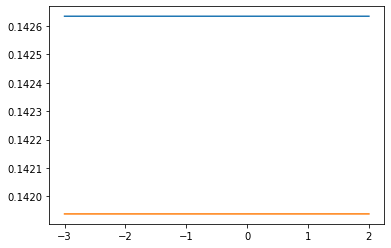

In [37]:
train_score=[]
test_score=[]
alpha_list=[0.001,0.01,0.1,1,10,100]
for alpha in alpha_list:
    model_lasso=Lasso(alpha=alpha,max_iter=10000)
    model_lasso.fit(train_X_ml,train_y)
    train_score.append(model_lasso.score(train_X_ml,train_y))
    test_score.append(model_lasso.score(test_X_ml,test_y))
plt.plot(np.log10(alpha_list),train_score)
plt.plot(np.log10(alpha_list),test_score)
plt.show()

In [38]:
#test1
lasso1= Lasso(alpha=0.01, max_iter=100000).fit(train_X_ml, train_y)

print("훈련 세트의 정확도 : {:.2f}".format(lasso1.score(train_X_ml, train_y)))

print("테스트 세트의 정확도 : {:.2f}".format(lasso1.score(test_X_ml, test_y)))

print("사용한 특성의 수 : {}".format(np.sum(lasso1.coef_ != 0)))

print("사용한 max_iter : {}".format(lasso1.n_iter_))

훈련 세트의 정확도 : 0.14
테스트 세트의 정확도 : 0.14
사용한 특성의 수 : 12
사용한 max_iter : 31


In [39]:
# --> 차이점이 보이지 않아 default값으로 구현
model_lasso=Lasso()

In [41]:
model_lasso.fit(train_X_ml,train_y)

Lasso()

In [42]:
pred_lasso = model_lasso.predict(test_X_ml)
pred_lasso

array([18161989.12592663, 17764477.846391  ,  9252983.86332782, ...,
       23862823.84866511,  9106021.34633059, 17952191.04222284])

## 7. Modeling - DL, NLP, shop_name
word embedding and embedding vector

1. make vocabulary set (tk)
2. using vocab set -> index encoding (seq_data)
3. padding with 0 -> pad_seq_data
- vocabulary set (tk)
    - shop_name : 116,918 개의 단어 set
    - shop_name + shop_type_big + shop_type_small : 114,967 개의 단어 set
- nlp input length -> 13
    - shop_name : 8
    - shop_type_big : 3
    - shop_type_small : 5
    - text_concat : 15
- shop_name : 0.75 acc
- shop_name + shop_type_big + shop_type_small : 0.80
- shop_name + shop_type_big + shop_type_small + geo : 0.80

In [43]:
from keras.preprocessing.text import Tokenizer

tk = Tokenizer()
tk.fit_on_texts(input_data['concat_text'])

print(list(tk.word_index.items())[:20])
print("\nvocab words 개수 : ", len(tk.word_index.items()))

[('전문점', 1), ('미분류', 2), ('음식', 3), ('카페', 4), ('한식', 5), ('소매', 6), ('분식', 7), ('커피숍', 8), ('다방', 9), ('디저트', 10), ('유흥주점', 11), ('강남구', 12), ('퓨전요리', 13), ('별식', 14), ('수산물', 15), ('마포구', 16), ('편의점', 17), ('송파구', 18), ('일반', 19), ('영등포구', 20)]

vocab words 개수 :  114955


In [44]:
from keras.preprocessing.sequence import pad_sequences

seq_data = tk.texts_to_sequences(input_data['concat_text'])
print("seq_data[0]: ", seq_data[0])

pad_seq_data = pad_sequences(seq_data)
print("pad_seq_data.shpae: ", pad_seq_data.shape)

nlp_input_length = pad_seq_data[0].shape[0]
print("nlp_input_length", nlp_input_length)

seq_data[0]:  [12994, 67, 137, 67, 43, 259]
pad_seq_data.shpae:  (2694599, 16)
nlp_input_length 16


In [45]:
def word_embedding(df, nlp_input_length) :
    seq_data = tk.texts_to_sequences(df)
    pad_seq_data = pad_sequences(seq_data, nlp_input_length)
    word_embedding = pad_seq_data
    return word_embedding

train_X_dl = word_embedding(train_X['concat_text'], nlp_input_length)
valid_X_dl = word_embedding(valid_X['concat_text'], nlp_input_length)
test_X_dl = word_embedding(test_X['concat_text'], nlp_input_length)

print(len(train_X))
print(len(train_X_dl))
print(len(valid_X))
print(len(valid_X_dl))
print(len(test_X))
print(len(test_X_dl))   

1724543
1724543
431136
431136
538920
538920


In [52]:
from keras import Sequential
from keras.layers import *
import tensorflow as tf
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

def create_model(input_dim, output_dim, input_length=nlp_input_length) : 
    model = Sequential()
    model.add(Embedding(input_dim, output_dim, input_length = nlp_input_length))    
    model.add(Flatten())
    model.add(Dense(1, activation='relu'))
    model.add(Dense(len(set(input_data_y)), activation='linear'))
    
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['MeanSquaredError'])
    return model

input_dim = len(tk.word_index) + 1
output_dim = 10

model_dl = create_model(input_dim, output_dim)
model_dl.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 16, 10)            1149560   
                                                                 
 flatten_3 (Flatten)         (None, 160)               0         
                                                                 
 dense_6 (Dense)             (None, 1)                 161       
                                                                 
 dense_7 (Dense)             (None, 2630314)           5260628   
                                                                 
Total params: 6,410,349
Trainable params: 6,410,349
Non-trainable params: 0
_________________________________________________________________


In [53]:
hist = model_dl.fit(train_X_dl, train_y, validation_data=(valid_X_dl, valid_y), epochs=3, batch_size=64)

Epoch 1/3
  244/26946 [..............................] - ETA: 6:30:04 - loss: 499228543549440.0000 - mean_squared_error: 499228543549440.0000

KeyboardInterrupt: 

In [ ]:
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='test loss')
plt.xticks(range(len(hist.history['loss'])))
plt.xlabel('epoch')
plt.ylabel('precision')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [ ]:
pred_dl= model_dl.predict(test_X_dl)
pred_dl

## 7. Evaluation

In [ ]:
def plot_history(history):
    #hist = pd.DataFrame(history.history)
    #history['epoch'] = history.epoch
    
    plt.figure(figsize=(8,12))
    
    plt.subplot(2,1,1)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error')
    plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
    plt.legend()
    
    plt.subplot(2,1,2)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error')
    plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
    plt.legend()
    plt.show()
    
def show_pred(test_y, pred) :
    true_y = test_y.to_numpy()
    true_y = np.ravel(true_y)
    
    df_result = pd.DataFrame(list(zip(true_y, pred)), columns=['true_y', 'prediction'])
    return df_result

def show_mse_rmse(test_y, pred) :
    mse = mean_squared_error(test_y, pred)
    print("mse : %f" % mse)
    
    rmse = np.sqrt(mse)
    print("rmse: %f \n" %rmse)

def show_r2_score(test_y, pred, test_X) : 
    r2 = r2_score(pred, test_y)
    print("r2 : %f " % r2)
    adj_r2 = 1 - (1-r2)*(test_X.shape[0]-1)/(test_X.shape[0]-test_X.shape[1]-1)
    print("adj_r2_score : %f \n" % adj_r2)
    
def show_prediction_error(test_y, pred) :
    true_y = test_y.to_numpy()
    true_y = np.ravel(true_y)
    error = pred - true_y
    plt.hist(error, bins=25)
    plt.xlabel("Prediction Error")
    _ = plt.ylabel("Count")
    
def feature_importance(model_xgb) : 
    %matplotlib inline
    plt.rcParams['axes.unicode_minus'] = False
    font_path = "C:/Windows/Fonts/NGULIM.TTF"
    font = fm.FontProperties(fname=font_path).get_name()
    rc('font', family=font)

    fig, ax = plt.subplots(figsize=(10,12))
    plot_importance(model_xgb, ax=ax)
    
def graph(pred, test_label) :
    plt.figure(figsize=(16, 9))
    plt.plot(test_label, label = 'actual')
    plt.plot(pred, label = 'prediction')
    plt.legend()
    plt.show()

In [ ]:
# ML model 
# XGB
show_pred(test_y, pred_xgb)

In [ ]:
show_mse_rmse(test_y, pred_xgb)
show_r2_score(test_y, pred_xgb, test_X)

In [ ]:
# DL model 
show_pred(test_y, pred_dl)

In [ ]:
show_mse_rmse(test_y, pred_dl)
show_r2_score(test_y, pred_dl, test_X_dl)